In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from numpy.random import multivariate_normal
from sklearn.linear_model import lasso_path
from scipy.optimize import fminbound
from scipy.stats import norm

%matplotlib inline

# The boundary curve  q*

The Matlab code at https://github.com/wjsu/fdrlasso has been used to work out q*.

In [2]:
def fdrlasso(tpp, delta, epsi):
    """
    This function calculates the Lasso trade-off curve given tpp (true
    positive proportion), delta = n/p (shape of the design matrix, or
    subsampling rate), and epsi = k/p (sparsity ratio).
    All tpp, delta, and epsi are between 0 and 1; if the
    pair (delta, epsi) is above the Donoho-Tanner phase transition, tpp
    should be no larger than u^\star = powermax(delta, epsi)
    """
    if tpp > powermax(delta, epsi):
        return None

    if tpp == 0:
        return 0

    # make stepsize smaller for higher accuracy
    stepsize = 0.1
    tmax = max(10, np.sqrt(delta/epsi/tpp) + 1)
    tmin = tmax - stepsize

    while tmin > 0:
        if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
            break
            
        tmax = tmin
        tmin = tmax - stepsize

    if tmin <= 0:
        stepsize = stepsize/100
        tmax = max(10, sqrt(delta/epsi/tpp) + 1)
        tmin = tmax - stepsize
        while tmin > 0:
            if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
                break

            tmax = tmin
            tmin = tmax - stepsize
  
    diff = tmax - tmin
    while diff > 1e-6:
        tmid = 0.5*tmax + 0.5*tmin
        if lsandwich(tmid, tpp, delta, epsi) > rsandwich(tmid, tpp):
            tmax = tmid
        else: 
            tmin = tmid
        
        diff = tmax - tmin

    t = (tmax + tmin)/2

    q = 2*(1 - epsi)*norm.cdf(-t)/(2*(1 - epsi)*norm.cdf(-t) + epsi*tpp)

    return q

def lsandwich(t, tpp, delta, epsi):
    Lnume = (1-epsi)*(2*(1+t**2)*norm.cdf(-t) - 2*t*norm.pdf(t)) + epsi*(1+t**2) - delta
    Ldeno = epsi*((1+t**2)*(1-2*norm.cdf(-t)) + 2*t*norm.pdf(t))
    L = Lnume/Ldeno
    return L

def rsandwich(t, tpp):
    R = (1 - tpp)/(1 - 2*norm.cdf(-t))
    return R

# highest power for delta < 1 and epsilon > epsilon_phase
def powermax(delta, epsilon):
    if delta >= 1:
        return 1

    epsilon_star = epsilonDT(delta)
    
    if epsilon <= epsilon_star:
          return 1
    
    power = (epsilon - epsilon_star)*(delta - epsilon_star)/epsilon/(1 - epsilon_star) + epsilon_star/epsilon
    return power

def epsilonDT(delta):
    minus_f = lambda x: -(1+2/delta*x*norm.pdf(x) - 2/delta*(1+x**2)*norm.cdf(-x))/(1+x**2-2*(1+x**2)*norm.cdf(-x)+2*x*norm.pdf(x))*delta
    alpha_phase = fminbound(minus_f, 0, 8)
    epsi = -minus_f(alpha_phase)
    
    return epsi

In [3]:
def boundary_curve(delta, epsi):
    """Compute the boundary curve q*"""
    
    tpps = np.arange(100) / 100
    boundary_curve_lst = np.array([fdrlasso(tpp=tpp, delta=delta, epsi=epsi) for tpp in tpps])
    
    return tpps, boundary_curve_lst

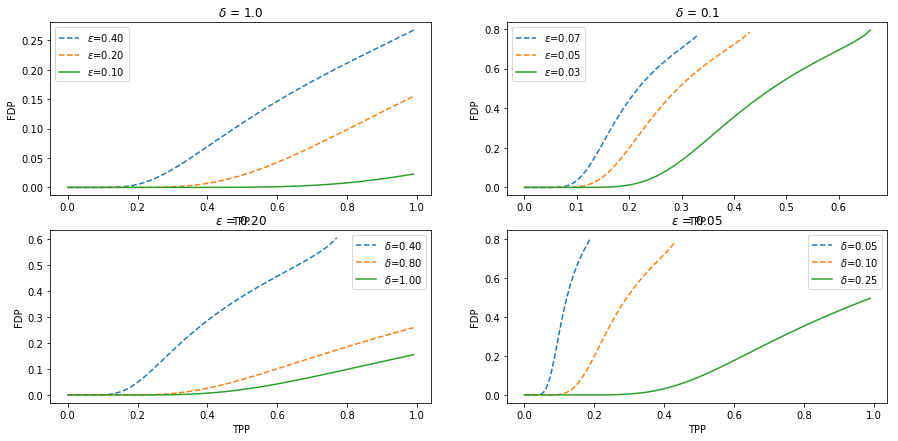

In [4]:
plt.figure(figsize=(15, 7))

linestyle = ["--", "--", "-"]

epsilons = [(0.4, 0.2, 0.1), (.07, .05, .03)]
for i, delta in enumerate([1., .1]):
    plt.subplot(2, 2, i+1)
    for j, epsilon in enumerate(epsilons[i]):
        tpps, boundary_curve_lst = boundary_curve(delta=delta, epsi=epsilon)
        plt.plot(tpps, boundary_curve_lst, linestyle[j], label=r"$\epsilon$=%.2f" % epsilon)
    plt.title(r"$\delta$ = %.1f" % delta)
    plt.xlabel("TPP")
    plt.ylabel("FDP")
    plt.legend()

deltas = [(.4, .8, 1.), (.05, .1, .25)]
for i, epsilon in enumerate([.2, .05]):
    plt.subplot(2, 2, i+3)
    for j, delta in enumerate(deltas[i]):
        tpps, boundary_curve_lst = boundary_curve(delta=delta, epsi=epsilon)
        plt.plot(tpps, boundary_curve_lst, linestyle[j], label=r"$\delta$=%.2f" % delta)

    plt.title(r"$\epsilon$ = %.2f" % epsilon)
    plt.xlabel("TPP")
    plt.ylabel("FDP")
    plt.legend()
    
plt.show()

# The Lasso trade-off diagram

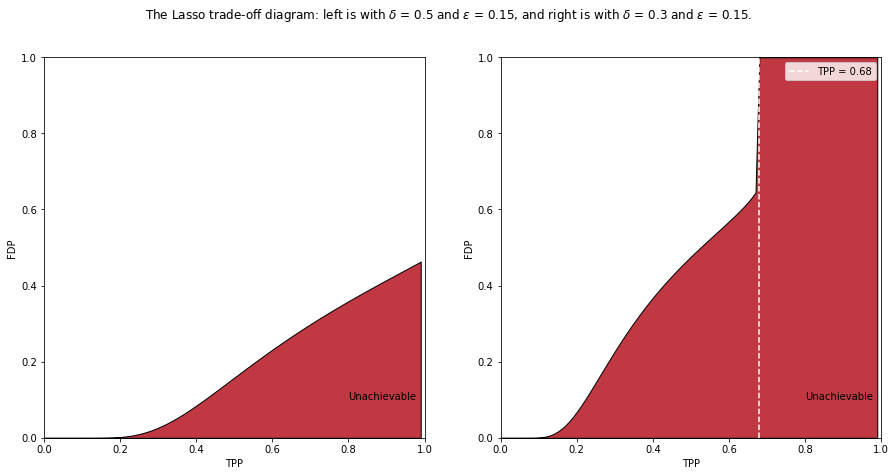

In [5]:
plt.figure(figsize=(15,7))
plt.suptitle(r"The Lasso trade-off diagram: left is with $\delta$ = 0.5 and $\epsilon$ = 0.15, and right is with $\delta$ = 0.3 and $\epsilon$ = 0.15.")

for i, (delta, epsilon) in enumerate([(.5, .15), (.3, .15)]):
    plt.subplot(1, 2, i+1)
    tpps, boundary_curve_lst = boundary_curve(delta=delta, epsi=epsilon)
    if (None in boundary_curve_lst):
        index = tpps[np.where(boundary_curve_lst == None)[0][0]]
        plt.axvline(index, linestyle="--", color="white", label="TPP = %.2f" % index)
        plt.legend()
    boundary_curve_lst[boundary_curve_lst == None] = 1.
    plt.fill_between(tpps, np.array(boundary_curve_lst, dtype=float), facecolor='#BF3842', edgecolor="black")
    plt.text(0.8, 0.1, 'Unachievable')
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.xlabel("TPP")
    plt.ylabel("FDP")
    
plt.show();

# Numerical illustration

In [6]:
def fdp_tpp_curve(n=1000, p=1000, epsilon=.2, n_alphas=100, return_mean=False):
    k = int(epsilon * p) 
    fdp_list = np.zeros(n_alphas*10)
    tpp_list = np.zeros(n_alphas*10)
    
    beta = np.append(np.ones(k), np.zeros(p - k))
    for j in range(10):
        X = np.random.normal(0, 1, (n, p))
        y = np.dot(X, beta) + np.random.normal(0, 1, n)

        path = 1.*(lasso_path(X, y, n_alphas=n_alphas, fit_intercept=False)[1] != 0)

        for i in range(n_alphas):
            path_i = path[:, i]
            sum_path = sum(path_i)
            
            fdp_list[i+j*n_alphas] = ((sum((path_i != beta) * (path_i == 1.)) / sum_path) if sum_path != 0 else 0)
            tpp_list[i+j*n_alphas] = sum((path_i == beta) * (beta == 1.)) / k
            
    if (return_mean):
        fdp_mean = np.zeros(n_alphas)
        tpp_mean = np.zeros(n_alphas)
        for i in range(n_alphas):
            fdp_mean[i] = np.mean(fdp_list[np.arange(0, n_alphas*10, n_alphas)+i])
            tpp_mean[i] = np.mean(tpp_list[np.arange(0, n_alphas*10, n_alphas)+i])
            
        return fdp_mean, tpp_mean
    
    
    return fdp_list, tpp_list

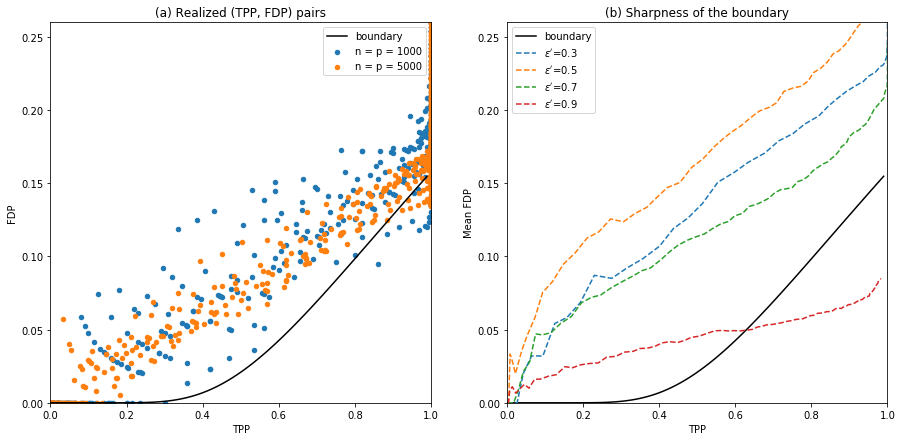

In [7]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
tpps, boundary_curve_lst = boundary_curve(delta=1, epsi=.2)
plt.plot(tpps, boundary_curve_lst, color="black", label="boundary")
for n in [1000, 5000]:
    fdp_list, tpp_list = fdp_tpp_curve(n, n, .2)
    plt.scatter(tpp_list, fdp_list, s=20, label="n = p = %d" % n)
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.xlim(0., 1.)
plt.ylim(0., .26)
plt.title("(a) Realized (TPP, FDP) pairs")
plt.legend()

plt.subplot(1, 2, 2)
epsilons = np.arange(3, 10, 2) / 10
tpps, boundary_curve_lst = boundary_curve(delta=1, epsi=.2)
plt.plot(tpps, boundary_curve_lst, color="black", label="boundary")
for epsilon in epsilons:
    fdp_list, tpp_list = fdp_tpp_curve(1000, 1000, epsilon, return_mean=True)
    plt.plot(tpp_list, fdp_list, "--", label=r"$\epsilon'$=%.1f" % epsilon)

plt.xlabel("TPP")
plt.ylabel("Mean FDP")
plt.legend()
plt.xlim(0., 1.)
plt.ylim(0., .26)
plt.title("(b) Sharpness of the boundary")
plt.show();

# TPP at time of first false selection - FDP at time of last true selection

In [8]:
n = p = 1000
epsilon = .2
k = int(epsilon * p) 
beta = np.append(np.ones(k), np.zeros(p - k))
fdp_list = np.zeros(100)
tpp_list = np.zeros(100)
for i in range(100):
    X = np.random.normal(0, 1, (n, p))
    y = np.dot(X, beta) + np.random.normal(0, 1, n)
    path = 1.*(lasso_path(X, y, n_alphas=100, fit_intercept=False)[1] != 0)
    
    fdp_val = 0.
    for j in range(99):
        path_j = path[:, j]
        sum_path = sum(path_j)
        fdp_val = ((sum((path_j != beta) * (path_j == 1.)) / sum_path) if sum_path != 0 else 0)
        tpp_list[i] = sum((path_j == beta) * (beta == 1.)) / k
        if (fdp_val != 0.):
            break
            
    tpp_val = 0.
    for j in range(99):
        path_j = path[:, j]
        sum_path = sum(path_j)
        tpp_val = sum((path_j == beta) * (beta == 1.)) / k
        fdp_list[i] = ((sum((path_j != beta) * (path_j == 1.)) / sum_path) if sum_path != 0 else 0)
        if (tpp_val == 1.):
            break

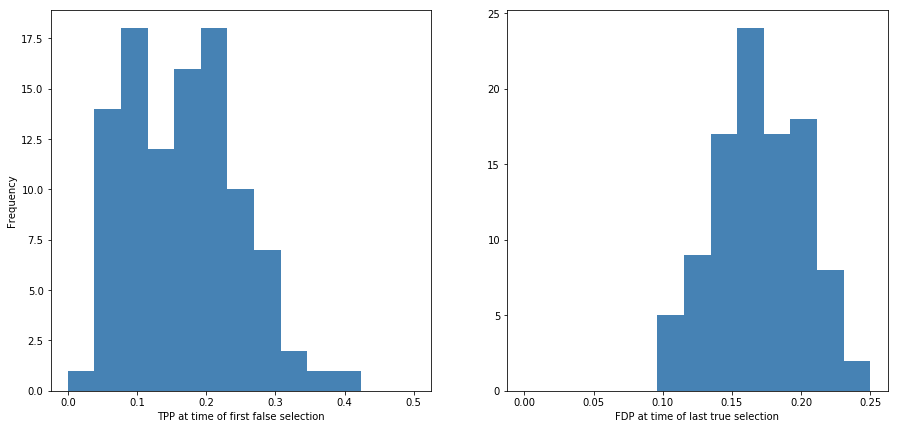

In [9]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.hist(tpp_list, bins=13, range=[0, 0.5], color='#4682B4')
plt.xlabel('TPP at time of first false selection')
plt.ylabel('Frequency')


plt.subplot(1,2,2)
plt.hist(fdp_list, bins=13, range=[0, 0.25], color='#4682B4')
plt.xlabel('FDP at time of last true selection')

plt.show()